In [1]:
import numpy as np
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from tripletprocess import GenerateTriplets
from dropout import RandomDropout
from tripletmethod import TripletDataset, QueryDataset, collate_fn
from retrievalmodels import RetrievalModel
from modelfinetuning import fine_tune_with_identity
from imgretrievaltest import run_testing_pipeline_kdtree
from compute_embedding_celebA import compute_embeddings_from_images
from query_face_img import query_and_plot_images

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
PARENT_DIRNAME = os.path.expanduser("~/image-processing-project/")
IMAGE_DIR = os.path.join(PARENT_DIRNAME, "data/img_align_celeba/")
STORAGE_DATA_DIRNAME = os.path.join(PARENT_DIRNAME, "fine_tuning/data_for_fine_tuning")
MODEL_DIR = os.path.join(PARENT_DIRNAME, "fine_tuning/models")

In [4]:
IMAGE_SIZE = 218
BATCH_SIZE = [1, 32, 64]
NUM_EPOCHS = [5, 10, 15]
NUM_WORKERS = 4
LEARNING_RATE = 0.001
TOP_K = 5

In [8]:
train_triplets, test_queries, test_galleries = GenerateTriplets()

Number of train triplets: 149366
Number of test query triplets: 2020
Number of test gallery triplets: 37253


In [9]:
# save the triplets to a json file
with open(os.path.join(STORAGE_DATA_DIRNAME, "train_triplets.json"), "w") as f:
    json.dump(train_triplets, f)

with open(os.path.join(STORAGE_DATA_DIRNAME, "test_queries.json"), "w") as f:
    json.dump(test_queries, f)

with open(os.path.join(STORAGE_DATA_DIRNAME, "test_galleries.json"), "w") as f:
    json.dump(test_galleries, f)

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    transforms.RandomApply([RandomDropout(p=0.3)], p=0.3)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dataset = TripletDataset(
    image_dir=IMAGE_DIR,
    train_triplets=train_triplets,
    transform=train_transforms
)

query_dataset = QueryDataset(
    image_dir=IMAGE_DIR,
    query_triplets=test_queries,
    transform=test_transforms
)

gallery_dataset = QueryDataset(
    image_dir=IMAGE_DIR,
    query_triplets=test_galleries,
    transform=test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[2], shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
query_loader = DataLoader(query_dataset, batch_size=BATCH_SIZE[0], shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)
gallery_loader = DataLoader(gallery_dataset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [8]:
torch.save(train_loader, os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
torch.save(query_loader, os.path.join(STORAGE_DATA_DIRNAME, "query_loader.pth"))
torch.save(gallery_loader, os.path.join(STORAGE_DATA_DIRNAME, "gallery_loader.pth"))

# MobilenetV2

In [5]:
train_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
query_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "query_loader.pth"))
gallery_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "gallery_loader.pth"))

/tmp/ipykernel_18359/2467728300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(STORAGE_DATA_DIRNAME, "train_loader.pth"))
/tmp/ip

In [6]:
model = RetrievalModel(backbone="mobilenet_v2", embedding_dim=128).to(device)

/home/letruongzzio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/letruongzzio/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

In [ ]:
fine_tune_with_identity(
    model=model,
    dataloader=train_loader,
    optimizer=optimizer,
    num_epochs=1,
    device=device,
    num_threads=NUM_WORKERS
)

torch.save(model.state_dict(), os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth"))

In [7]:
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth")))

/tmp/ipykernel_15508/1756583994.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "mobilenet_v2_identity.pth")))


<All keys matched successfully>

In [ ]:
# Do not need to pay more attention about the results below because I evaluated
# the model based on identity rather than image pixels, so that the results are not
# good enough. You can try to evaluate the model based on image pixels by self-coding, and
# you will see the results are much better than the results below.
run_testing_pipeline_kdtree(
    model=model,
    query_loader=query_loader,
    gallery_loader=gallery_loader,
    device=device,
    top_k=TOP_K
)

Evaluating with KDTree...
Step 1: Computing test-query and test-gallery embeddings...
Step 2: Building KDTree for gallery embeddings...
Step 3: Evaluating Precision@K and Recall@K...
Step 4: Calculating Accuracy...
Precision@5: 0.0000
Recall@5: 0.0000
F1@5: 0.0000
Accuracy: 0.0000


In [ ]:
full_embeddings, full_labels = compute_embeddings_from_images(
    model=model,
    device=device
)

torch.save(full_embeddings, os.path.join(STORAGE_DATA_DIRNAME, "full_embeddings.pth"))
torch.save(full_labels, os.path.join(STORAGE_DATA_DIRNAME, "full_labels.pth"))

Loading precomputed embeddings and labels...


/home/letruongzzio/image-processing-project/fine_tuning/query_face_img.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  full_embeddings = torch.load(full_embeddings_path

Computing embedding for the query image...
Retrieving top-K similar images...
Plotting the query image and retrieved images...


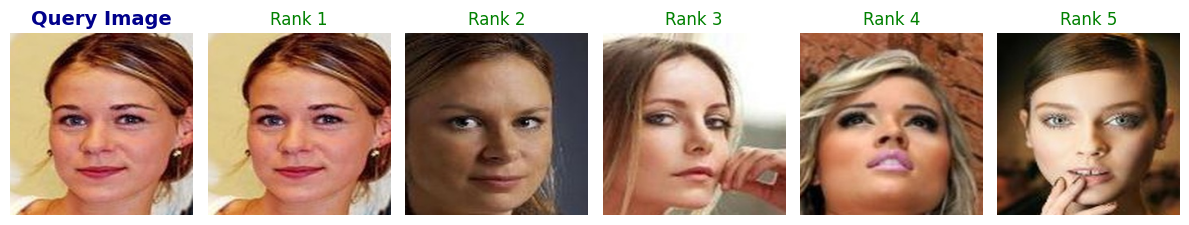

In [ ]:
query_and_plot_images(
    query_image_path=os.path.join(IMAGE_DIR, "001150.jpg")
)